### 1. Import Dependecies

In [2]:
import os
from enum import Enum
import seaborn as sns
from pydantic import BaseModel
from dotenv import load_dotenv
import numpy as np # alias
import openai, groq
import pandas as pd # alias

load_dotenv()

True

### 2. Basic Information

In [3]:
df = pd.read_csv('data/raw/ChurnModelling.csv')
df.head()

,RowNumber,CustomerId,Firstname,Lastname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Grace,Williams,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,2,15647311,David,Jones,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Hank,Williams,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Eva,Taylor,699,France,Female,NaN,1,0.00,2,0,0,93826.63,0
4,5,15737888,Grace,Miller,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0


In [4]:
df.isnull().sum()

RowNumber            0
CustomerId           0
Firstname            7
Lastname             6
CreditScore          0
Geography            0
Gender             108
Age                600
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

### 3. Handling Missing Values

#### 3.1 Imputation

The possible ways to do this are:

- Filling the missing data with the mean or median value if it’s a numerical variable.
- Filling the missing data with mode if it’s a categorical value.
- Filling the numerical value with 0 or -999, or some other number that will not occur in the data. This can be done so that the machine can recognize that the data is not real or is different.
- Filling the categorical value with a new type for the missing values.

##### 3.2.1 Age

In [5]:
mean = df['Age'].mean()
meadian = df['Age'].median()
mean = round(mean,2)

<Axes: xlabel='Age', ylabel='Count'>

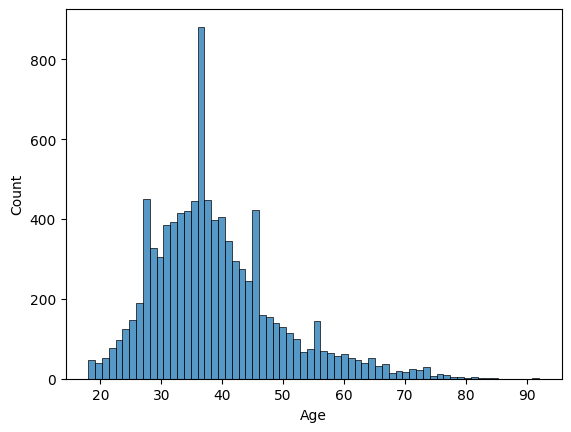

In [6]:
sns.histplot(df['Age'])

In [7]:
df_impute = df.copy()

In [8]:
df_impute.loc[:,'Age'] = df_impute['Age'].fillna(mean)

In [9]:
df_impute.isnull().sum()

RowNumber            0
CustomerId           0
Firstname            7
Lastname             6
CreditScore          0
Geography            0
Gender             108
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

##### 3.2.2 Gender

In [10]:
class Gender(Enum):
    MALE = "Male"
    FEMALE = "Female"

class GenderPrediction(BaseModel):
    firstname:str
    lastname:str
    pred_gender:Gender

def predict_gender(
                firstname: str,
                lastname: str
                ):
    prompt = f"""
                What is the most likely gender (Male or Female) for someone with the first name '{firstname}'
                and last name '{lastname}' ?

                Your response only consists of one word: Male or Female
                """
    
    response = groq.Groq().chat.completions.create(
                                                    model="llama-3.3-70b-versatile",
                                                    messages=[{
                                                                "role": "user",
                                                                "content": prompt
                                                            }]
                                                    )
    predicted_gender = response.choices[0].message.content.strip()
    prediction = GenderPrediction(
                                firstname=firstname ,
                                lastname=lastname,
                                pred_gender=predicted_gender
                                )
    return prediction.pred_gender.value

In [11]:
predict_gender("dinod","Imanjith")

'Male'

In [12]:
missing_gender_index = df['Gender'].isnull()
for index in df_impute[missing_gender_index].index:
    firstName = df_impute.loc[index,'Firstname']
    lastName = df_impute.loc[index,'Lastname']
    gender = predict_gender(firstName, lastName)
    
    if gender:
        df_impute.loc[index, 'Gender'] = gender
        print(f"{firstName} {lastName} : {gender}")
    else:
        print(f"{firstName} {lastName} : No Gender Detected")

Eva Wilson : Female
Ivy Johnson : Female
David Taylor : Male
Frank Davis : Male
Jack Wilson : Male
David Miller : Male
Eva Taylor : Female
Grace Johnson : Female
Hank Miller : Male
Frank Williams : Male
Alice Davis : Female
Alice Brown : Female
Alice Garcia : Female
Bob Jones : Male
Jack Davis : Male
Grace Williams : Female
Ivy Jones : Female
David Smith : Male
David Miller : Male
Eva Williams : Female
Frank Garcia : Male
Alice Wilson : Female
Carol Jones : Female
Hank Davis : Male
Ivy Williams : Female
Hank Smith : Male
Ivy Jones : Female
Alice Brown : Female
Eva Taylor : Female
Carol Williams : Female
Jack Williams : Male
Ivy Brown : Female
David Brown : Male
Bob Smith : Male
Frank Wilson : Male
Bob Williams : Male
Ivy Johnson : Female
Jack Taylor : Male
David Davis : Male
David Garcia : Male
Eva Brown : Female
Frank Wilson : Male
Jack Davis : Male
Eva Miller : Female
Grace Williams : Female
Bob Jones : Male
David Taylor : Male
Frank Smith : Male
Ivy Jones : Female
David Williams : M

In [13]:
df_impute.isnull().sum()

RowNumber          0
CustomerId         0
Firstname          7
Lastname           6
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [14]:
df_impute= df_impute.drop(
    columns=[
        'RowNumber',
        'CustomerId',
        'Firstname',
        'Lastname'
    ]
)

In [15]:
df_impute.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.00,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41.00,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42.00,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,38.91,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43.00,2,125510.82,1,1,1,79084.10,0


In [16]:
# saving handled data set
df_impute.to_csv(
                'data/processed/ChurnModelling_Missing_Values_Handled.csv', 
                index=False
                )